### Import Libraries

In [11]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

MODELS_DIR = "../models"
Path(MODELS_DIR).mkdir(exist_ok=True)


### Load Cleaned Employee Reviews

In [15]:
reviews_df = pd.read_csv("processed/employee_reviews_clean.csv")
print("Reviews shape:", reviews_df.shape)
reviews_df.head()


Reviews shape: (355, 7)


,positionName,salary,company,rating,reviewsCount,jobTypeConsolidated,clean_review
0,Pricing Analyst,"£70,000 - £85,000 a year",Urban Empire Recruitment,NaN,NaN,"Permanent, Full-time",Pricing Analyst
1,Lead AI / ML / Data Science Engineer,"£150,000 a year",Founding Teams,NaN,NaN,Part-time,Lead AI / ML / Data Science Engineer
2,Data Scientist,NaN,Depop,4.4,34.0,Permanent,Data Scientist
3,Research Fellow in data analysis and machine l...,NaN,UCL,4.1,256.0,"Permanent, Full-time",Research Fellow in data analysis and machine l...
4,Senior Data Scientist | Media & Entertainment.,"£70,000 a year",Nicholson Glover Consulting,NaN,NaN,Permanent,Senior Data Scientist | Media & Entertainment.


### Detect Review Text Column Automatically

In [16]:
possible_cols = ["clean_review", "review", "Review", "text", "body", "comments", "positionName"]

review_col = None
for col in possible_cols:
    if col in reviews_df.columns:
        review_col = col
        break

print("Detected review text column:", review_col)

if review_col is None:
    raise ValueError("Could not locate a valid review text column.")


Detected review text column: clean_review


In [17]:
reviews_df[review_col] = reviews_df[review_col].fillna("").astype(str)


### Generate Sentiment Labels

In [18]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(str(text))["compound"]
    if score >= 0.05:
        return 1    # positive
    elif score <= -0.05:
        return 0    # negative
    else:
        return np.nan  # neutral - skip

reviews_df["sentiment"] = reviews_df[review_col].apply(vader_sentiment)

# Remove neutral (nan) reviews
reviews_df = reviews_df.dropna(subset=["sentiment"]).reset_index(drop=True)

print("Sentiment counts:\n", reviews_df["sentiment"].value_counts())


Sentiment counts:
 sentiment
1.0    46
0.0     3
Name: count, dtype: int64


### Load SentenceTransformer Embedding Model

In [19]:
model = SentenceTransformer("all-MiniLM-L6-v2")


### Create Embeddings for Review Text

In [20]:
texts = reviews_df[review_col].tolist()

embeddings = model.encode(
    texts,
    show_progress_bar=True,
    convert_to_tensor=True
)

X = embeddings.cpu().numpy()
y = reviews_df["sentiment"].astype(int).values

print("Embedding shape:", X.shape)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding shape: (49, 384)


### Prepare Train/Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (39, 384)
Test shape: (10, 384)


### Train Sentiment Classifier (Logistic Regression)

In [22]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)
print("Training complete.")


Training complete.


### Evaluate Sentiment Model

Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      1.00      0.95         9

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10



c:\Users\vishwa\AppData\Local\anaconda3\envs\talent\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\vishwa\AppData\Local\anaconda3\envs\talent\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\vishwa\AppData\Local\anaconda3\envs\talent\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

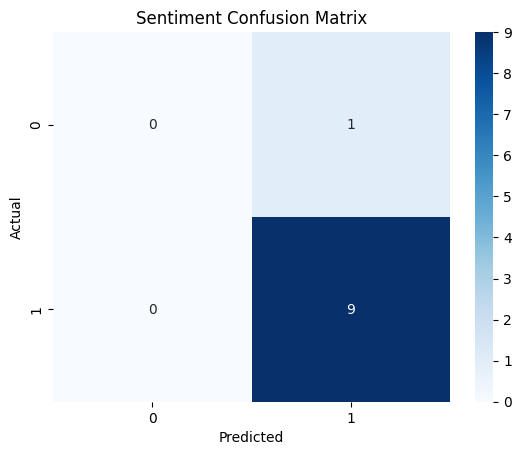

In [23]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Sentiment Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Save Sentiment Model

In [25]:
sentiment_model_path = r"C:\Guvi\Talent Intelligence & Workforce Optimization\notebooks\models/sentiment_model.pkl"

joblib.dump({
    "classifier": clf,
    "embedding_model": "all-MiniLM-L6-v2",
    "review_col": review_col
}, sentiment_model_path)

print("Sentiment model saved to:", sentiment_model_path)


Sentiment model saved to: C:\Guvi\Talent Intelligence & Workforce Optimization\notebooks\models/sentiment_model.pkl
